In [23]:
import numpy as np
import networkx as nx
from numpy.random import choice,random
import matplotlib.pyplot as plt
np.random.seed(42)

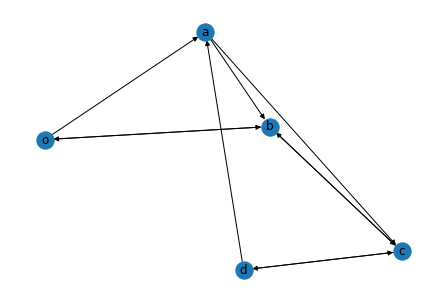

In [24]:
Lambda = np.array([[0,2/5,1/5,0,0],
                [0,0,3/4,1/4,0],
                [1/2,0,0,1/2,0],
                [0,0,1/3,0,2/3],
                [0,1/3,0,1/3,0]])
G = nx.DiGraph()
G.add_nodes_from(['o','a','b','c','d'])
G.add_weighted_edges_from([('o', 'a', 2/5), ('o', 'b', 1/5), ('a', 'b', 3/4), ('a', 'c', 1/4), ('b', 'o', 1/2), ('b', 'c', 1/2), ('c', 'b', 1/3), ('c', 'd', 2/3), ('d', 'a', 1/3), ('d', 'c', 1/3)])
nx.draw(G, with_labels = True)

In [25]:
W = Lambda
degrees = np.sum(W, axis = 1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W
w = np.sum(W, axis = 1)
w_star = np.max(w)
Q = Lambda / w_star
Q = Q + np.diag(np.ones(len(w)) - np.sum(Q, axis = 1))
Q_cum = np.cumsum(Q, axis = 1)

In [26]:
#Point A
def RandomWalk(G, start, end, Q, nodes, w):
    nodeSeq = [start]
    transition_times = [0]
    while True:
        start = choice(G.adj[start],1)[0]
        t_next =- np.log(np.random.rand()) / w
        nodeSeq.append(start)
        t_next += transition_times[-1]
        transition_times.append(t_next)
        if start == end:
            return nodeSeq, transition_times
        
def averageTime(start, end, num_steps, w):
    somma = 0
    for _ in range(num_steps):
        _, transition_times = RandomWalk(G, start, end, Q_cum, nodes, w)
        somma = somma + transition_times[-1]
    return somma / num_steps # average return time

nodes = ['o','a','b','c','d']
simulation = averageTime("a", "a", 10000, w_star)
print(simulation)

7.026341489629242


In [27]:
#Point B
n_nodes = G.number_of_nodes()
#define the set S and the remaining nodes R
S = [1]
#define the remaining nodes R
R = [node for node in range(n_nodes) if node not in S]
#restrict P to R x R and obtain hat(P)
hatP = P[np.ix_(R, R)]
hatw = w[np.ix_(R)]
#hat(x) is the solution of the linear system
hatx = np.linalg.solve((np.identity(n_nodes-len(S))-hatP),(np.ones(n_nodes-len(S))/hatw))
#hitting time = 0 if the starting node is in S
hitting_s = np.zeros(n_nodes)
#hitting time = hat(x) for nodes in R
hitting_s[R] = hatx
print('Expected hitting times on a: ',hitting_s)
tau_a = 1 / w[1] + P[1, :] @ hitting_s
print('Expected return time: ',tau_a)

Expected hitting times on a:  [3.57142857 0.         5.71428571 5.85714286 4.42857143]
Expected return time:  6.75


In [28]:
#Point C
simulation = averageTime("o", "d", 10000, w_star)
print(simulation)

8.46595194141912


In [29]:
#Point D
n_nodes = G.number_of_nodes()
S = [4]
R = [node for node in range(n_nodes) if node not in S]
hatP = P[np.ix_(R, R)]
hatw = w[np.ix_(R)]
hatx = np.linalg.solve((np.identity(n_nodes - len(S)) - hatP), (np.ones(n_nodes - len(S)) / hatw))
hitting_s = np.zeros(n_nodes)
hitting_s[R] = hatx
expected_od = hitting_s[0]
print(expected_od)
print("Error simulation",abs(simulation - expected_od))

8.785714285714285
Error simulation 0.3197623442951638


In [30]:
#Point E
#since the graph is strongly connected, the condensation graph is composed of a single sink;
#that sink is aperiodic and so x(t) converges to a consensus status.

#arbitrary initial condition
x = np.array([1,0,1,0,1])
for iter in range(500):
    x = P @ x
print(x)

[0.56521739 0.56521739 0.56521739 0.56521739 0.56521739]


In [31]:
#Point F
alfa_err = np.zeros(200)

#with numerical simulations
for i in range(200):
#since rand returns random values in [0,1], mu = 1/2
    x = np.random.rand(5)
    for n in range(500):
        x = P @ x
    alfa_err[i] = (1/2 - np.mean(x)) * (1/2 - np.mean(x))
print("The variance of the consensus state is:", np.mean(alfa_err), "\n")

w,v = np.linalg.eig(P.T)
#selects the eigenvalue 1 and print the eigenvector
for index in [i for i in range(len(G)) if np.isclose(w[i],1)]: 
    pi = v[:,index].real  # -> eigenvectors are complex but pi is real, so we convert it to real
    pi = pi / np.sum(pi)
    print("pi", index, "=", pi)
#uniform distribution, so the variance is 1/12
sigma = 1/12
res = np.sum(np.square(pi)) * sigma
print(res)

The variance of the consensus state is: 0.016601992306451107 

pi 0 = [0.13043478 0.17391304 0.26086957 0.26086957 0.17391304]
0.017800882167611845


x(0): [0.32661328 0.66500081 0.90800295 0.97771419 0.88679286]
The asymptotic state x is: [0.88679286 0.88679286 0.88679286 0.88679286 0.88679286]
The variance of the consensus state is: 0.08765319529831926 



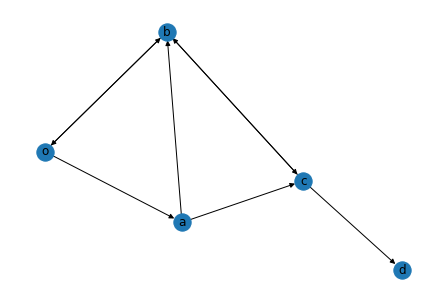

In [32]:
#Point G
G.remove_edges_from([('d', 'a'), ('d', 'c')])
nx.draw(G, with_labels = True)
W = nx.adjacency_matrix(G)
W = W.toarray()
W[4][4] = 0.00001   
degrees = np.sum(W, axis = 1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W
x = np.random.rand(5)
print('x(0):', x)
for iter in range(500):
    x = P @ x
print("The asymptotic state x is:", x)
#with numerical simulations
for i in range(200):
    #since rand returns random values in [0,1], mu = 1/2
    x = np.random.rand(5)
    var = np.var(x)
    for n in range(500):
        x = P @ x
    alfa_err[i] = (1/2 - np.mean(x)) * (1/2 - np.mean(x))
print("The variance of the consensus state is:", np.mean(alfa_err), "\n")

Initial state: [0.4222791  0.15368224 0.47811416 0.31793942 0.96788916]
The asymptotic state x: [0.61791622 0.59291816 0.81790076 0.31793942 0.96788916]


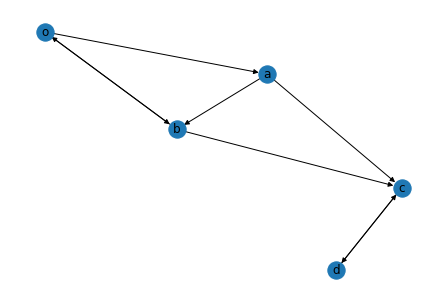

In [33]:
#Point H
G = nx.DiGraph()
G.add_weighted_edges_from([('o', 'a', 2/5), ('o', 'b', 1/5), ('a', 'b', 3/4), ('a', 'c', 1/4), ('b', 'o', 1/2), ('b', 'c', 1/2), ('c', 'd', 2/3), ('d', 'c', 1/3)])
nx.draw(G, with_labels = True)
#re-construct P
W = nx.adjacency_matrix(G)
W = W.toarray()
degrees = np.sum(W, axis = 1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W
x = np.random.rand(5)
print("Initial state:", x)
#check the result by running the averaging dynamics
for iter in range(500):
    x = P @ x   
print("The asymptotic state x:", x)